In [60]:
import cv2
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd



# Add the 'src' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'src'))
import Evaluator 
import Utils

In [61]:
# parameters for bright images
# smoothing kernel size 5, clahe== true

In [62]:
image_nr ="5"


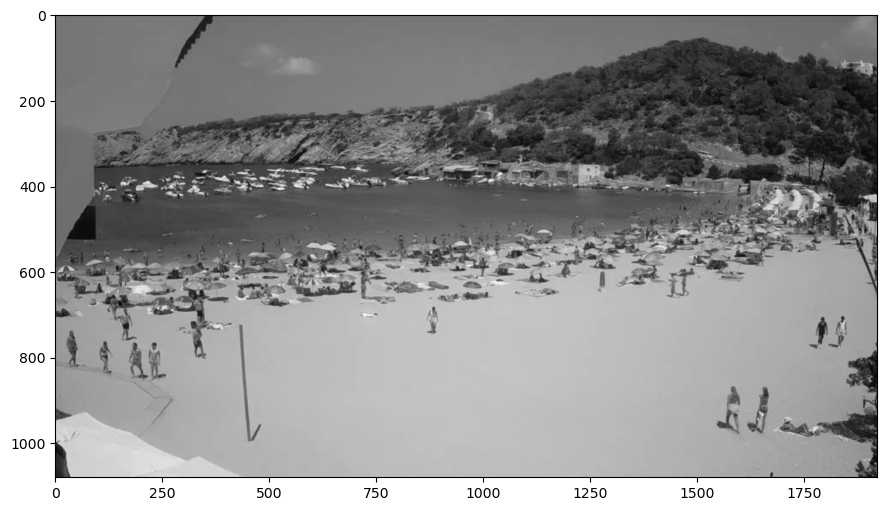

In [63]:
# Load the image
beach_occupied = cv2.imread("data/images/"+image_nr+".jpg")
# convert to RGB
beach_occupied = cv2.cvtColor(beach_occupied, cv2.COLOR_BGR2RGB)
# convert to grayscale
beach_occupied_gray = cv2.cvtColor(beach_occupied, cv2.COLOR_BGR2GRAY)

# remove noise
beach_occupied_gray_smoothed = cv2.GaussianBlur(beach_occupied_gray, (5, 5), 0)

# plot image
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_gray_smoothed, cmap='gray')

plt.show()


In [64]:
def boustrophedon_moving_average(image, pct):
    """
    Apply the moving average algorithm with boustrophedon scanning to a grayscale image.

    Parameters:
        image (numpy.ndarray): The input grayscale image as a 2D array.
        pct (float): Percentage threshold for deciding black or white pixel.

    Returns:
        numpy.ndarray: A binary image (2D array) with pixels set to black or white.
    """
    # Ensure input is a 2D grayscale image
    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D grayscale image.")

    # Dimensions of the image
    rows, cols = image.shape

    # Initialize moving average to 127 * n
    n = cols // 8
    M = 127 * n

    # Create output binary image
    output_image = np.zeros_like(image, dtype=np.uint8)

    # Define threshold multiplier based on percentage
    threshold_multiplier = (100 - pct) / 100

    # Implement boustrophedon scanning
    for i in range(rows):
        # Determine the direction of scanning (normal or reversed)
        if i % 2 == 0:  # Even row: left to right
            col_range = range(cols)
        else:  # Odd row: right to left
            col_range = range(cols - 1, -1, -1)

        for j in col_range:
            # Get the pixel intensity
            g_ij = image[i, j]

            # Compute the threshold
            threshold = (M / n) * threshold_multiplier

            # Apply threshold to determine binary output
            if g_ij < threshold:
                output_image[i, j] = 0  # Set to black
            else:
                output_image[i, j] = 255  # Set to white

            # Update moving average
            M = M - (M / n) + g_ij

    return output_image

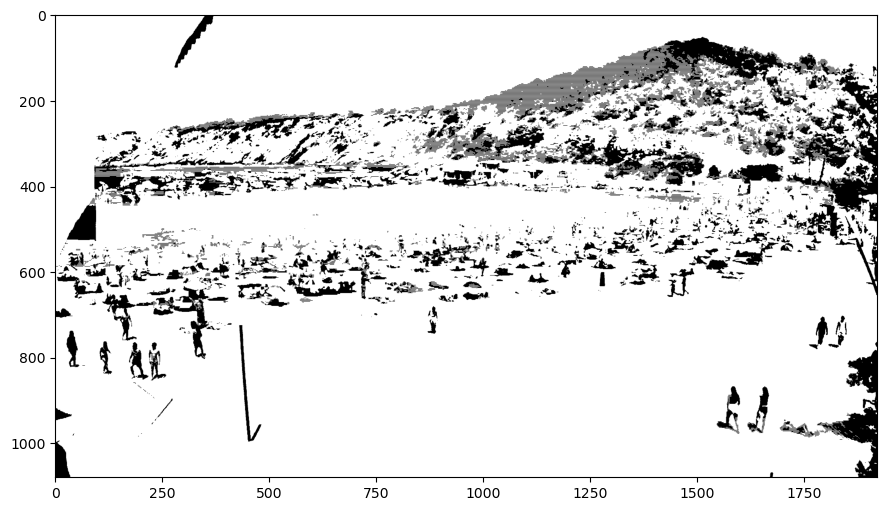

In [65]:
# apply background extraction
beach_occupied_background = boustrophedon_moving_average(beach_occupied_gray_smoothed, 20)

# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_background, cmap='gray')
plt.show()


In [66]:
def binarize_by_thresholding(img: np.ndarray, threshold: float) -> np.ndarray:
    """Returns a binary version of the image by applying a thresholding operation."""
    # YOUR CODE HERE:
    #   ...
    return (img >= threshold)*255

In [67]:
def binarize_by_hysteresis(img: np.ndarray, low_threshold: float, high_threshold: float) -> np.ndarray:
    """Returns a binary version of the image by applying a hysteresis operation."""
    out = np.zeros_like(img)
    binary_img = binarize_by_thresholding(img, low_threshold)
    _, label_img = cv2.connectedComponents(binary_img.astype('uint8'))
    labels = np.unique(label_img)
    for label in labels:
        # YOUR CODE HERE:
        #   See `np.any(...)` and `np.all(...)`.
        #   ...
        if label == 0:
            # Ignore label of background
            pass
        elif np.any(img[label_img == label] >= high_threshold):
            out[label_img == label] = 255
    return out

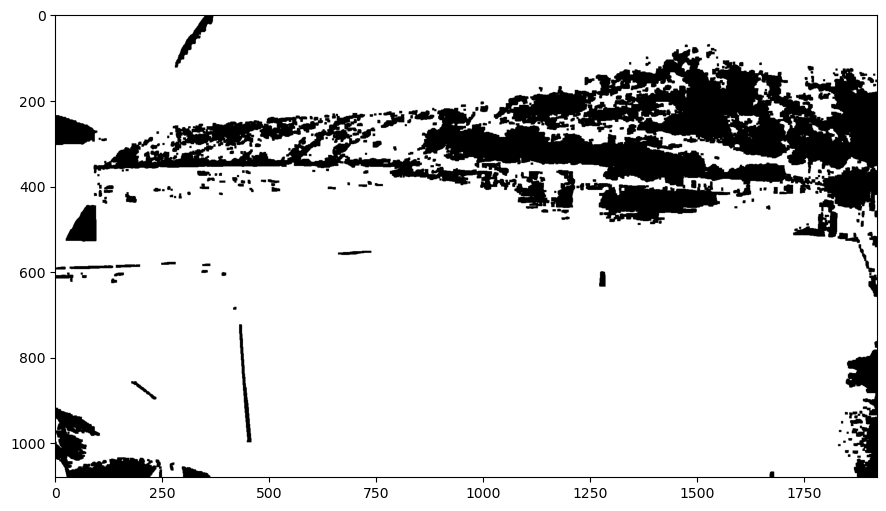

In [68]:
# load empty beach image
empty_beach = cv2.imread("data/images/0_empty.jpg")
# convert to binary image with histeresis method
empty_beach = cv2.cvtColor(empty_beach, cv2.COLOR_BGR2GRAY)
#
# apply clahe to improve contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
empty_beach = clahe.apply(empty_beach)
empty_beach = cv2.GaussianBlur(empty_beach, (5, 5), 0)
empty_beach = binarize_by_hysteresis(empty_beach, 80, 150)

# apply erosion to remove noise
kernel = np.ones((5, 5), np.uint8)
empty_beach = cv2.erode(empty_beach, kernel, iterations=1)



# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(empty_beach, cmap='gray')
plt.show()


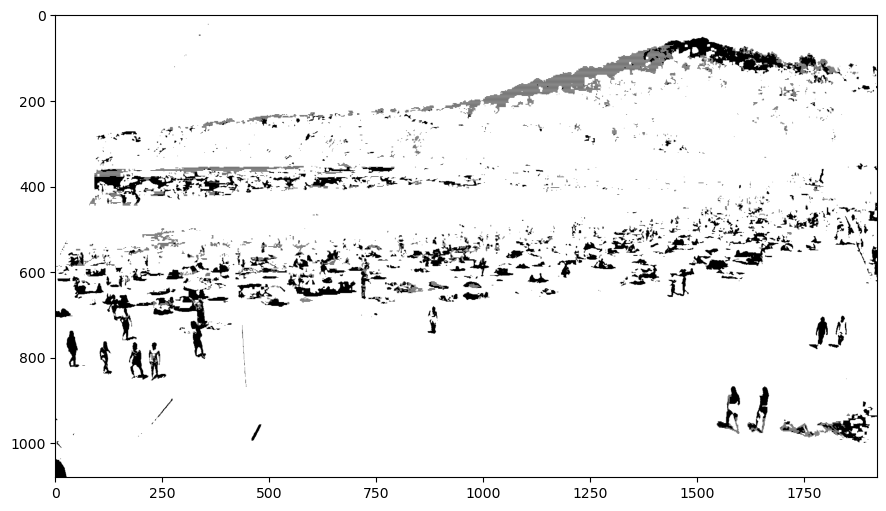

In [69]:
# set all pixels that are 0 in the beach_occupied_background and 0 in the empty_beach to 255 leaving the rest as 255
beach_occupied_foreground = np.where((beach_occupied_background == 0) & (empty_beach == 0), 255, beach_occupied_background)


# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied_foreground, cmap='gray')
plt.show()


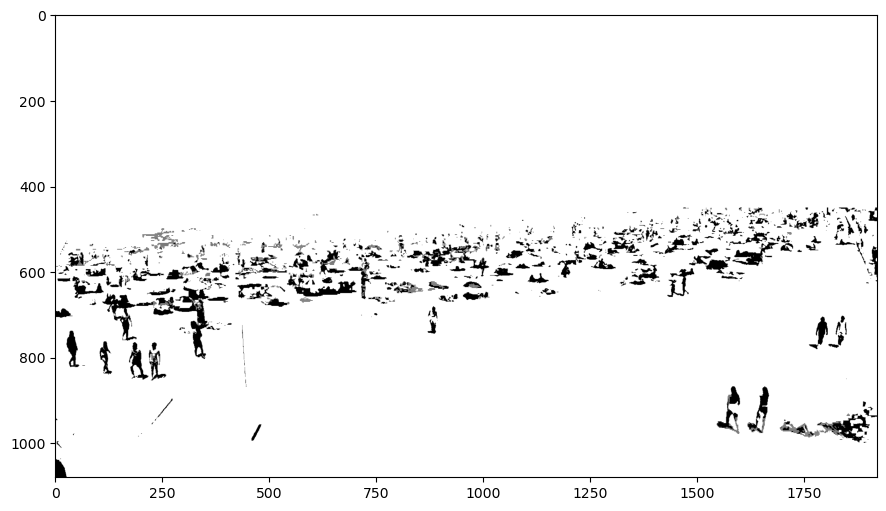

In [70]:
# set all pixes which have a lower y coordinate than 450 to white
beach_no_background=beach_occupied_foreground .copy()

beach_no_background[0:450,:]=255

# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(beach_no_background, cmap='gray')
plt.show()

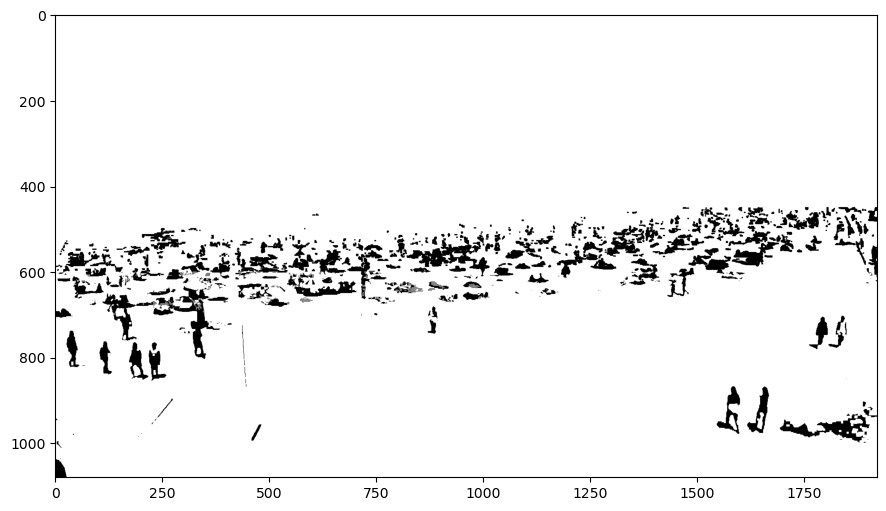

In [71]:
# apply opening for pixels in a y range of 420 and 700
# Select the region of interest (ROI) from row 420 to 700
kernel_dilate = np.ones((3, 3), np.uint8)
roi_dilate = beach_no_background[438:600, :]

# Apply dilation to fill in the gaps
roi_dilated = cv2.erode(roi_dilate, kernel_dilate, iterations=1)

kernel_open = np.ones((5, 5), np.uint8)

roi_open = beach_no_background[700:1080, :]
roi_opened = cv2.morphologyEx(roi_open, cv2.MORPH_OPEN, kernel_open, iterations=1)

# add the dilated roi back to the image

beach_no_background[438:600, :] = roi_dilated
beach_no_background[700:1080, :] = roi_opened



# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(beach_no_background, cmap='gray')
plt.show()

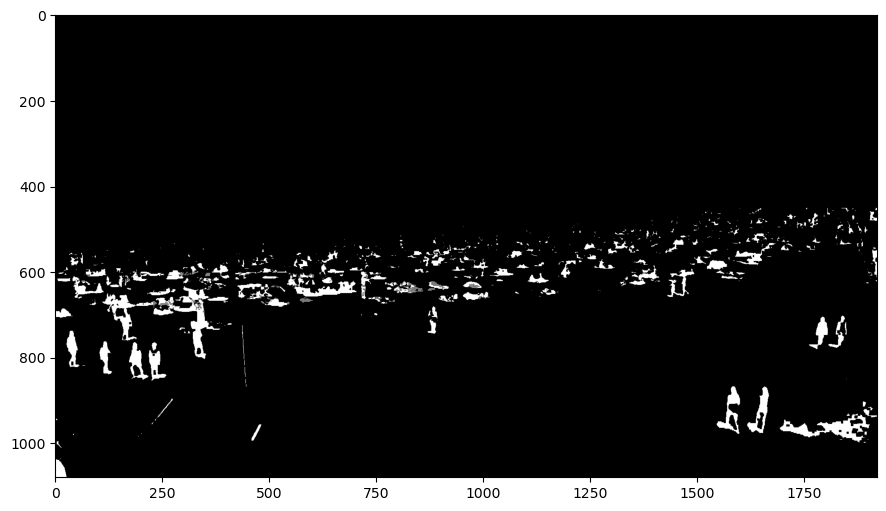

In [322]:
# switch black and white
beach_no_background = cv2.bitwise_not(beach_no_background)
# plot 
plt.figure(figsize=(12, 6))
plt.imshow(beach_no_background, cmap='gray')
plt.show()

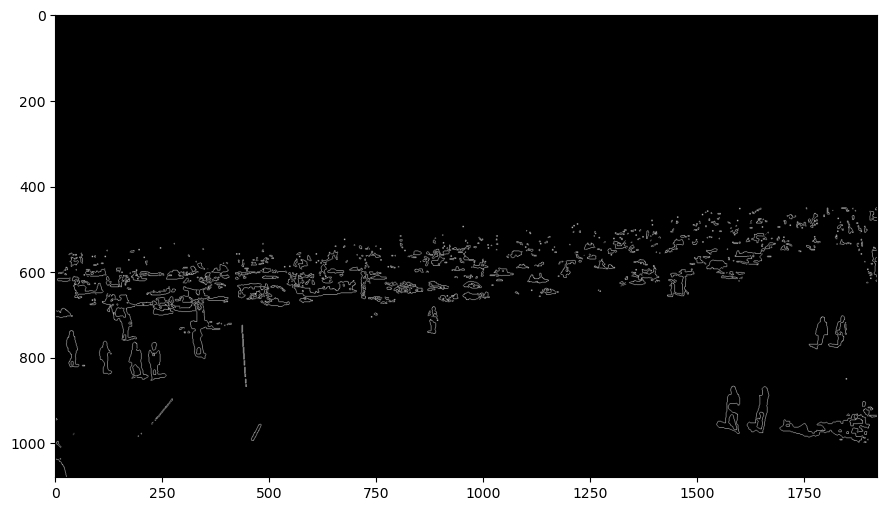

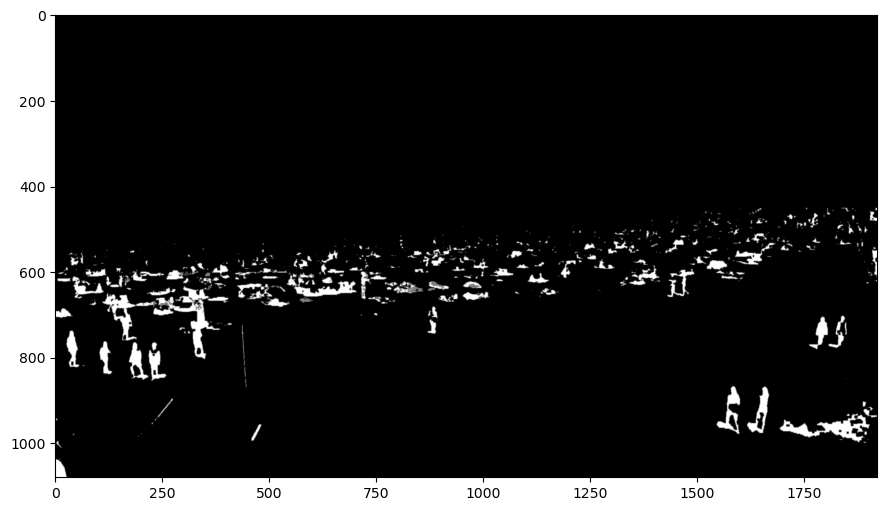

In [323]:
# smooth the image
beach_no_background_smoothed = cv2.GaussianBlur(beach_no_background, (3, 3), 0)

# plot binary image
plt.figure(figsize=(12, 6))
plt.imshow(beach_no_background_smoothed, cmap='gray')
plt.show()

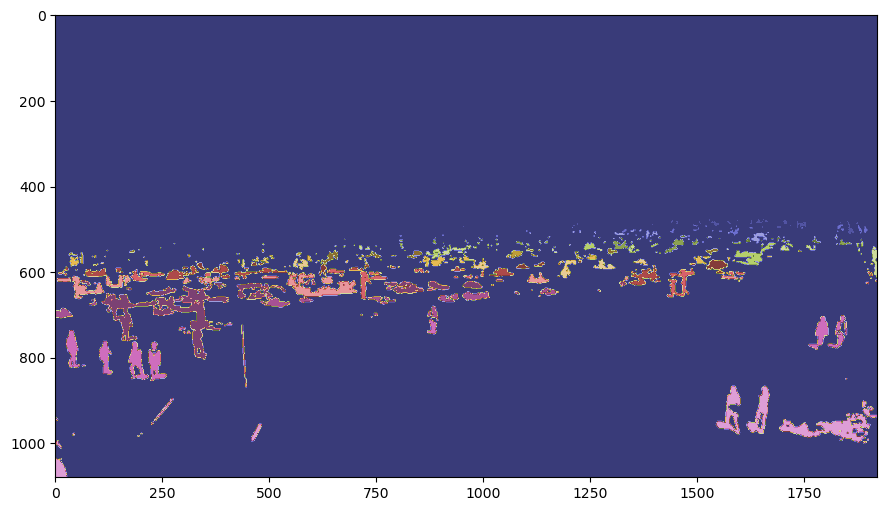

Number of connected components:  429


In [324]:



# find connected components with stats
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(beach_no_background_smoothed, connectivity=8)

# plot connected components
plt.figure(figsize=(12, 6))
plt.imshow(labels_im, cmap='tab20b')
plt.show()

#print number of connected components
print("Number of connected components: ", num_labels)




In [325]:
# create a dataframe with the connected components

df = pd.DataFrame(stats, columns=['left', 'top', 'width', 'height', 'area'])

# remove the first row which is the background
df = df.iloc[1:]

Number of connected components:  428


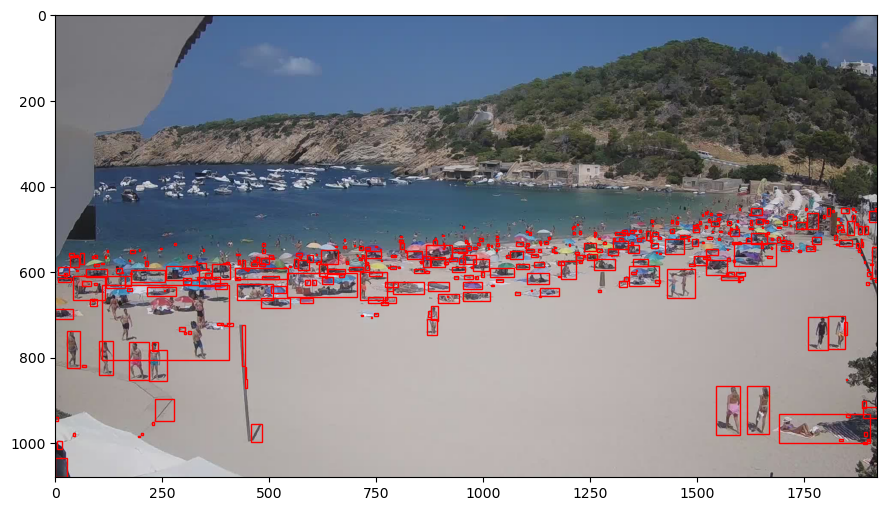

In [326]:
# plot the bounding boxes of each connected component
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied)
# print how many connected components are found
print("Number of connected components: ", len(df))
for i, row in df.iterrows():
    x, y, w, h = row[['left', 'top', 'width', 'height']]
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))

plt.show()

In [328]:
points = [(0, 603), (129, 593), (249, 582), (339, 577) , (425, 573), (538, 566), (666, 560),(784, 551), (902, 542), (1056, 534), (1189, 522), (1292, 513), (1403, 502), (1488, 483), (1558, 470), (1610, 455), (1625, 440), (1614, 425)]

# fit a curve to the points
curve = np.poly1d(np.polyfit([p[0] for p in points], [p[1] for p in points], 2))

Number of connected components:  158


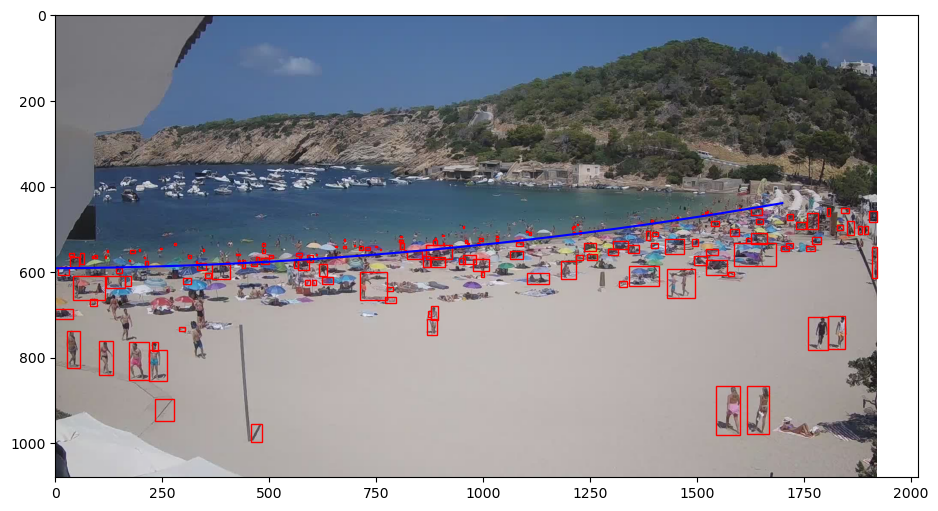

In [329]:
# post process the connected components

boxes = Utils.post_process_image(beach_occupied,stats, centroids, nms_threshold=0.5)

# plot the bounding boxes of each connected component
plt.figure(figsize=(12, 6))
plt.imshow(beach_occupied)
# print how many connected components are found
print("Number of connected components: ", len(boxes))
for box in boxes:
    x, y, w, h = box
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none'))
plt.plot(range(0, 1700), curve(range(0, 1700)), 'b-')
plt.show()